In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/v2-nba-player-database/NBA_PLAYERS.csv


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
df = pd.read_csv('/kaggle/input/v2-nba-player-database/NBA_PLAYERS.csv')

## 1. Data Exploration

In [4]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nSummary Statistics (Numerical Columns):")
print(df.describe())
print("\nSummary Statistics (Categorical Columns):")
print(df.describe(include=['object']))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5313 entries, 0 to 5312
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5313 non-null   object 
 1   Debut     5313 non-null   int64  
 2   Final     5313 non-null   int64  
 3   Position  5313 non-null   object 
 4   Height    5313 non-null   int64  
 5   Weight    5308 non-null   float64
 6   Birthday  5297 non-null   object 
 7   School    4917 non-null   object 
 8   HOF       5313 non-null   bool   
 9   Active    5313 non-null   bool   
 10  G         5313 non-null   int64  
 11  PTS       5313 non-null   float64
 12  TRB       5021 non-null   float64
 13  AST       5313 non-null   float64
 14  FG%       5278 non-null   float64
 15  FG3%      3656 non-null   float64
 16  FT%       5060 non-null   float64
 17  eFG%      4156 non-null   float64
 18  PER       4965 non-null   float64
 19  WS        5312 non-null   float64
dtypes: bool(2), floa

In [5]:
# Check for missing values
df.isnull().sum()

Name           0
Debut          0
Final          0
Position       0
Height         0
Weight         5
Birthday      16
School       396
HOF            0
Active         0
G              0
PTS            0
TRB          292
AST            0
FG%           35
FG3%        1657
FT%          253
eFG%        1157
PER          348
WS             1
dtype: int64

In [6]:
# Check for duplicates
df.duplicated().sum()

0

In [7]:
# Check class distribution for HOF
print("\nHOF Class Distribution:")
df['HOF'].value_counts(normalize=True)


HOF Class Distribution:


HOF
False    0.966685
True     0.033315
Name: proportion, dtype: float64

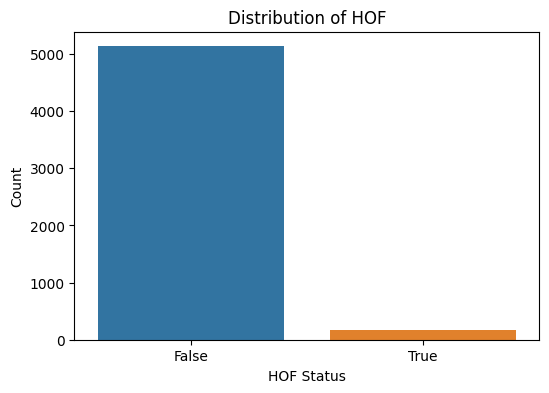

In [8]:
# Visualize HOF distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='HOF', data=df)
plt.title('Distribution of HOF')
plt.xlabel('HOF Status')
plt.ylabel('Count')
plt.show()

#### **Observations**

**1. Missing Values:**

- Missing data is present in several columns: Weight (5), Birthday (16), School (396), TRB (292), FG% (35), FG3% (1,657), FT% (253), eFG% (1,157), PER (348), and WS (1). FG3% and eFG% have the highest missingness (31% and 22%, respectively), likely due to historical data where 3-point stats were not recorded.
- No missing values in key columns like Name, Debut, Final, HOF, or G, a strong foundation for the target variable and basic career metrics.
  
**2. Summary Statistics - Numerical Columns:**

- Debut and Final years range from 1947 to 2025, with means around 1990 and 1994, respectively
- Height averages 78 inches (6’6”) with a standard deviation of 3.6 inches, and Weight averages 209 lbs with a standard deviation of 25.8 lbs, reasonable variability.
- Performance metrics like PTS (mean 6.4, max 30.1), TRB (mean 3.0, max 22.9), and AST (mean 1.4, max 11.2) show a wide range, with some outliers (e.g., PER max 88.3, min -52.7), which may require capping or transformation.
- FG% and FT% have maximum values of 100%, but eFG% reaches 150%, a sign of potential data errors or unique cases that need investigation.
  
**3. Summary Statistics - Categorical Columns:**

- Position has 7 unique values (e.g., ['Guard'], ['Forward', 'Center']), with ['Guard'] being the most frequent (1,920 occurrences). This warrants multi-label encoding.
- School has 996 unique values, with ['Kentucky'] as the top entry (118 times), an indication of high cardinality that may require encoding strategies like target encoding.
- Birthday has 4,858 unique values, with some duplication (e.g., October 25, 1948, appearing 3 times), another reflection of data entry issues or multiple players with the same birthdate.
  
**4. HOF Class Distribution:**

- The target variable HOF is highly imbalanced, with 96.67% False (5,136 players) and 3.33% True (177 players). This warrants techniques like class weighting, oversampling (SMOTE), or using metrics like recall and F1-score over accuracy.
- The bar plot visually reinforces this imbalance, with a dominant False class of around 5,000 counts and a small True class (around 200 counts).

## 2. Data Preprocessing

In [10]:
# Copy the original df
df_processed = df.copy()

In [11]:
# Handle missing values in numerical columns by imputating with median
num_cols = ['Weight', 'TRB', 'FG%', 'FG3%', 'FT%', 'eFG%', 'PER', 'WS']
num_imputer = SimpleImputer(strategy='median')
df_processed[num_cols] = num_imputer.fit_transform(df_processed[num_cols])

In [12]:
# Handle missing values in categorical columns by imputating with 'Unknown'
cat_cols = ['Birthday', 'School']
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df_processed[cat_cols] = cat_imputer.fit_transform(df_processed[cat_cols])

In [13]:
# Create total career stats by multiplying averages by games played (G)
df_processed['Total_Career_Points'] = df_processed['PTS'] * df_processed['G']
df_processed['Total_Career_Rebounds'] = df_processed['TRB'] * df_processed['G']
df_processed['Total_Career_Assists'] = df_processed['AST'] * df_processed['G']

In [15]:
# Additional derived features
df_processed['Career_Length'] = df_processed['Final'] - df_processed['Debut']
df_processed['Avg_Seasonal_Points'] = df_processed['Total_Career_Points'] / df_processed['Career_Length'].replace(0, 1)  # Avoid division by zero
df_processed['Peak_Performance'] = df_processed[['PTS', 'TRB', 'AST', 'PER']].max(axis=1)  # Peak stat across key metrics
df_processed['Efficiency_Per_Game'] = df_processed['PER'] / df_processed['G'].replace(0, 1)  # Efficiency normalized by games

In [16]:
# Encode categorical variables
# Multi-label encoding for Position
mlb = MultiLabelBinarizer()
position_encoded = pd.DataFrame(mlb.fit_transform(df_processed['Position'].str.strip('[]').str.split(', ')),
                               columns=[f'Pos_{cat}' for cat in mlb.classes_],
                               index=df_processed.index)
df_processed = pd.concat([df_processed.drop('Position', axis=1), position_encoded], axis=1)

In [17]:
# One-hot encode School (high cardinality, using top N schools and 'Other' category)
# Limit to top 50 schools to manage dimensionality
top_schools = df_processed['School'].value_counts().index[:50]
df_processed['School'] = df_processed['School'].apply(lambda x: x if x in top_schools else 'Other')
df_processed = pd.get_dummies(df_processed, columns=['School'], prefix='School')

In [18]:
# One-hot encode Birthday (simplified as a categorical variable due to 'Unknown')
df_processed = pd.get_dummies(df_processed, columns=['Birthday'], prefix='Bday')

In [19]:
# Scale numerical features
num_cols_to_scale = ['Height', 'Weight', 'G', 'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 'eFG%', 'PER', 'WS', 
                     'Career_Length', 'Total_Career_Points', 'Total_Career_Rebounds', 'Total_Career_Assists', 
                     'Avg_Seasonal_Points', 'Peak_Performance', 'Efficiency_Per_Game']
scaler = StandardScaler()
df_processed[num_cols_to_scale] = scaler.fit_transform(df_processed[num_cols_to_scale])

In [20]:
# Drop non-predictive columns (Name) and target for modeling preparation
X = df_processed.drop(columns=['Name', 'HOF', 'Active'])
y = df_processed['HOF']

## 3. Exploratory Data Analysis

In [24]:
# Select a subset of numerical features for visualization
key_features = ['Total_Career_Points', 'Total_Career_Rebounds', 'Total_Career_Assists', 
                'Career_Length', 'Peak_Performance', 'Efficiency_Per_Game', 'PTS', 'TRB', 'AST', 'PER']
X_subset = df_processed[key_features]

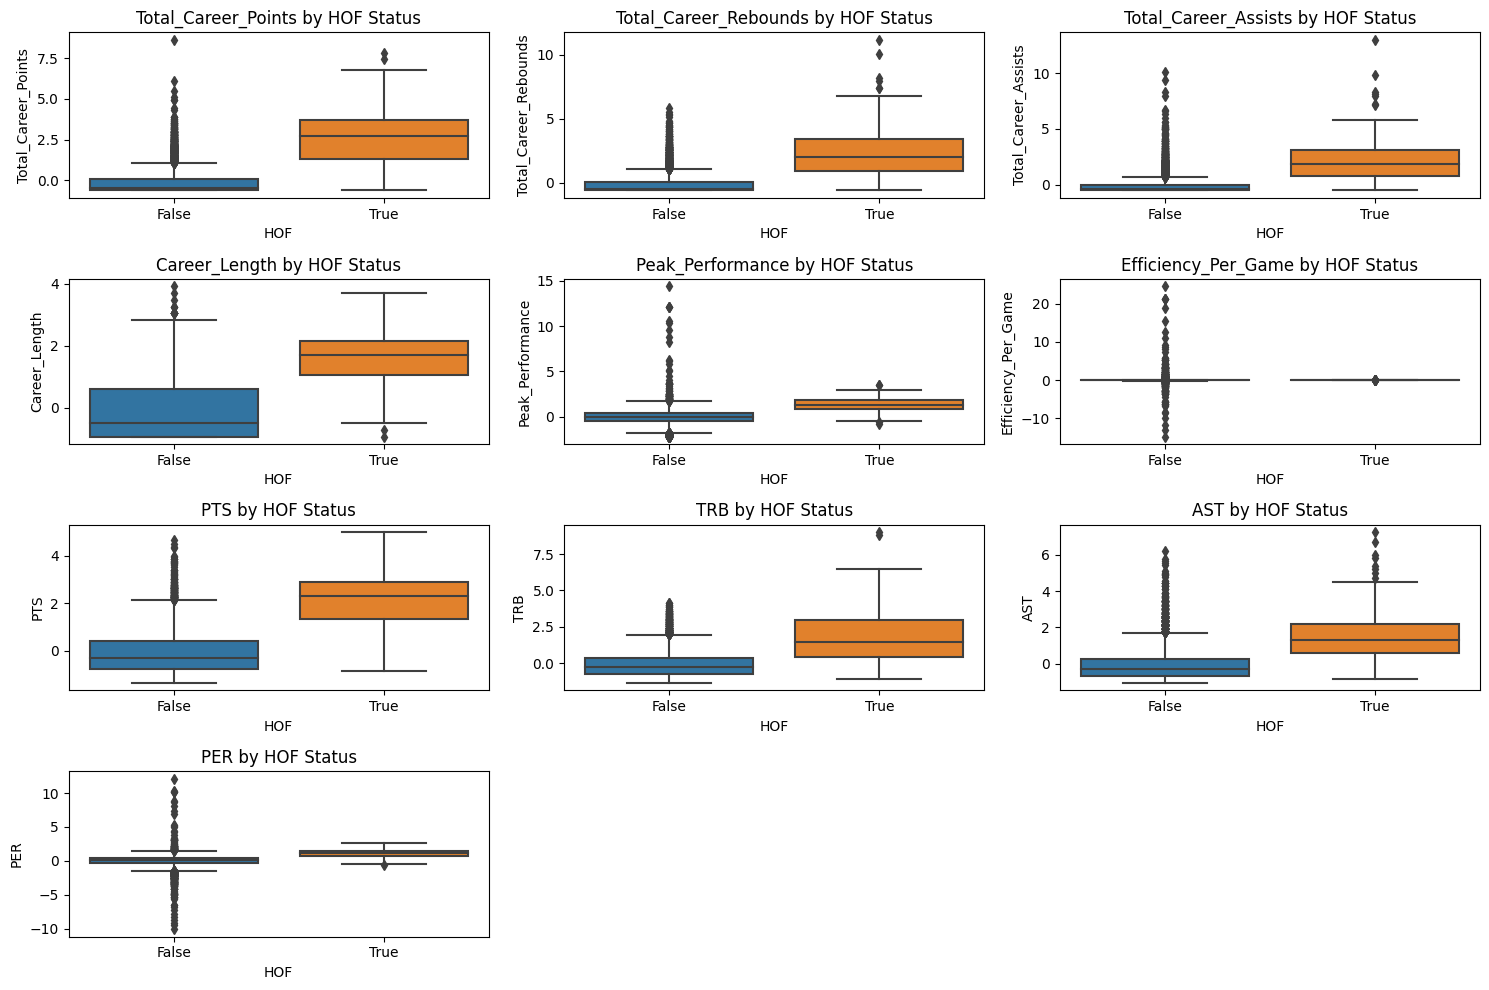

In [25]:
# Visualize distributions of key features by HOF status
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='HOF', y=feature, data=df_processed)
    plt.title(f'{feature} by HOF Status')
plt.tight_layout()
plt.show()

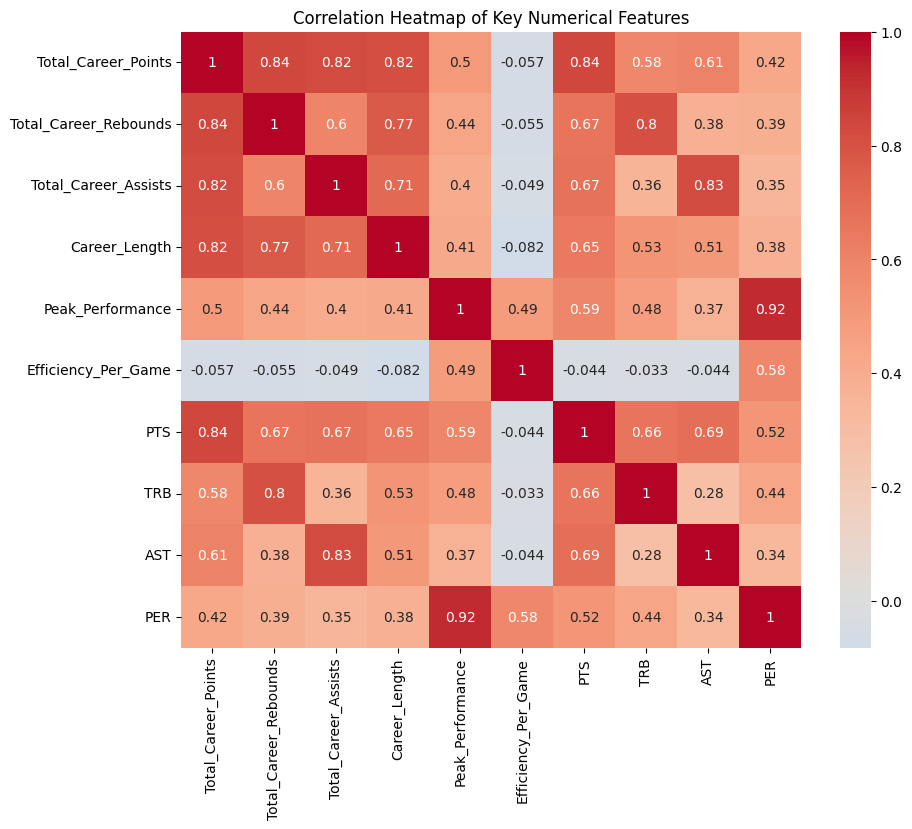

In [27]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(X_subset.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Key Numerical Features')
plt.show()

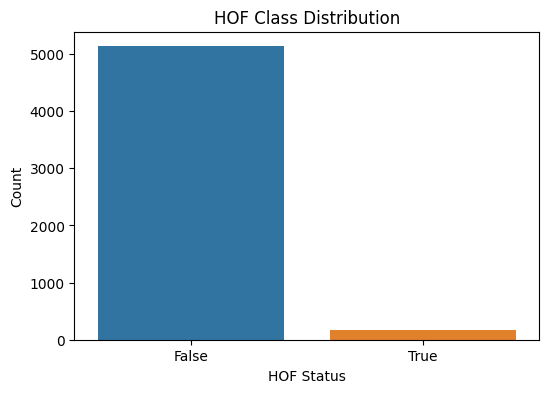

In [28]:
# Check class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='HOF', data=df_processed)
plt.title('HOF Class Distribution')
plt.xlabel('HOF Status')
plt.ylabel('Count')
plt.show()

In [29]:
# Mutual Information for feature importance (top 10)
mi_scores = mutual_info_classif(X, y)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_top10 = mi_series.sort_values(ascending=False).head(10)
print("\nTop 10 Features by Mutual Information:")
print(mi_top10)


Top 10 Features by Mutual Information:
WS                       0.065617
Total_Career_Points      0.061053
Total_Career_Rebounds    0.056220
PTS                      0.053901
Avg_Seasonal_Points      0.051286
Peak_Performance         0.050857
Total_Career_Assists     0.050153
PER                      0.048147
G                        0.045135
AST                      0.038841
dtype: float64


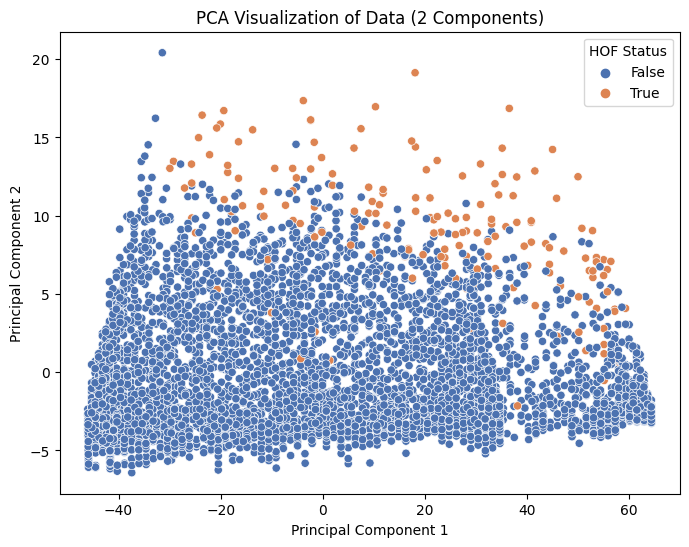

In [30]:
# PCA to visualize high-dimensional data (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_processed['HOF'], palette='deep')
plt.title('PCA Visualization of Data (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='HOF Status')
plt.show()

#### **Analysis of Results**

**1. Boxplots of Key Features by HOF Status:**

- **Total_Career_Points, Total_Career_Rebounds, Total_Career_Assists:** HOF True players show significantly higher medians and wider interquartile ranges (IQRs) compared to False, with some extreme outliers (e.g., Total_Career_Points ~5 for True vs. ~0 for False). This suggests career totals are strong predictors of HOF status.
- **Career_Length:** True HOF players have a higher median career length (~2-3 years vs. ~0 for False), indicating longevity is a factor, though the overlap is notable.
- **Peak_Performance:** True HOF players exhibit higher medians (~10-15 vs. ~0-5 for False), reflecting standout seasons as a key indicator.
- **Efficiency_Per_Game:** Little separation between True and False, with medians near 0 and high variability, suggesting per-game efficiency may be less discriminative after normalization.
- **PTS, TRB, AST, PER:** True HOF players consistently show higher medians (e.g., PTS ~2-3, PER ~5-10 vs. ~0 for False), with outliers indicating exceptional performances, aligning with HOF criteria.
  
**2. Correlation Heatmap:**

- Strong positive correlations exist among career totals (Total_Career_Points, Total_Career_Rebounds, Total_Career_Assists) and averages (PTS, TRB, AST), with coefficients ranging from 0.60 to 0.84. This multicollinearity may inflate feature importance but can be addressed with feature selection or regularization.
- Career_Length correlates moderately with totals (0.71-0.82), supporting the longevity hypothesis.
- Efficiency_Per_Game shows weak correlations (e.g., -0.057 to 0.58), confirming its limited discriminative power.
- PER has a strong correlation with Peak_Performance (0.92), suggesting redundancy that could be pruned.

**3. Mutual Information Scores:**

- The top 10 features by mutual information highlight WS (0.0656), Total_Career_Points (0.0611), and Total_Career_Rebounds (0.0562) as the most informative, aligning with boxplot observations.
- PTS (0.0539), Avg_Seasonal_Points (0.0513), and Peak_Performance (0.0509) also rank high, reinforcing the importance of scoring and peak metrics.
- G (0.0451) and AST (0.0388) are relevant but less impactful, while Efficiency_Per_Game is absent from the top 10, consistent with its weak separation.
- The scores are relatively low (max 0.0656), likely due to the high dimensionality (4,934 features), suggesting feature selection or dimensionality reduction is warranted.

**4. PCA Visualization:**

- The 2-component PCA plot shows some separation between False (blue) and True (orange) classes, with True points slightly shifted toward positive Principal Component 1 values. However, the overlap is substantial, indicating that two components capture limited variance, likely due to the high dimensionality.
- This suggests PCA with more components or alternative methods (e.g., t-SNE) might improve class separation, but for now, it confirms the challenge of distinguishing HOF status in reduced space.

In [32]:
# Select top 10 features based on mutual information
top_features = ['WS', 'Total_Career_Points', 'Total_Career_Rebounds', 'PTS', 
                'Avg_Seasonal_Points', 'Peak_Performance', 'Total_Career_Assists', 
                'PER', 'G', 'AST']
X = df_processed[top_features]
y = df_processed['HOF']

In [33]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [34]:
# Train Random Forest with class weight for imbalance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [35]:
# Predict and evaluate
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

In [36]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Model Evaluation Metrics:
Accuracy: 0.9708
Precision: 0.5909
Recall: 0.3714
F1-Score: 0.4561
ROC-AUC: 0.8923


In [37]:
# Feature importance
feature_importance = pd.DataFrame({'feature': top_features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                 feature  importance
0                     WS    0.250128
2  Total_Career_Rebounds    0.159962
1    Total_Career_Points    0.140560
6   Total_Career_Assists    0.118895
4    Avg_Seasonal_Points    0.089377
3                    PTS    0.078165
8                      G    0.048070
5       Peak_Performance    0.042362
9                    AST    0.039500
7                    PER    0.032982


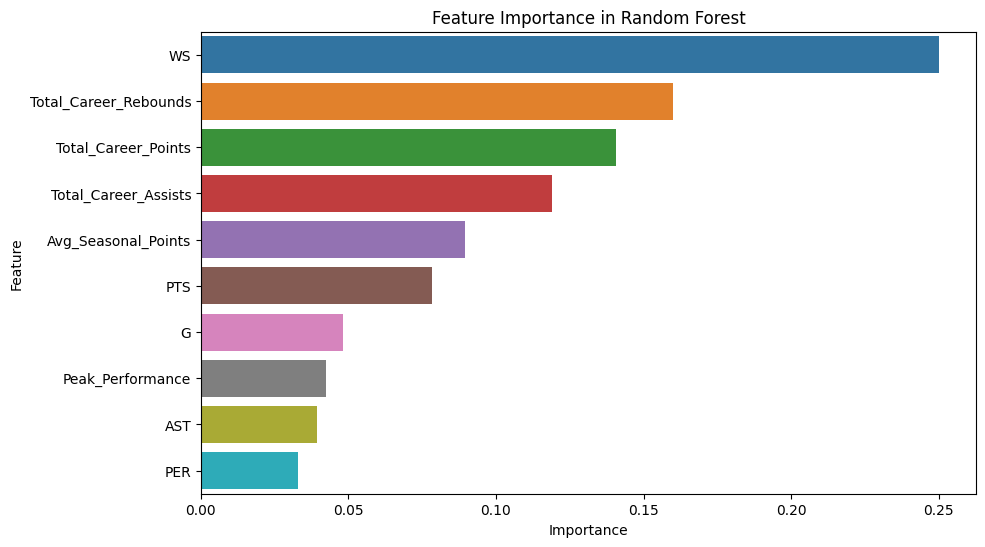

In [38]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 4. Model Evaluation and Tuning

In [39]:
# Use the copied DataFrame for tuning
df_tuning = df_processed.copy()

In [40]:
# Select top 10 features
top_features = ['WS', 'Total_Career_Points', 'Total_Career_Rebounds', 'PTS', 
                'Avg_Seasonal_Points', 'Peak_Performance', 'Total_Career_Assists', 
                'PER', 'G', 'AST']
X = df_tuning[top_features]
y = df_tuning['HOF']

In [41]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [42]:
# Define parameter grid with class weights
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

In [45]:
# Initialize Random Forest and GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 5},
                                          {0: 1, 1: 10}],
                         'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [46]:
# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

In [47]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Best Parameters:", grid_search.best_params_)
print("\nModel Evaluation Metrics (Tuned):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Best Parameters: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

Model Evaluation Metrics (Tuned):
Accuracy: 0.9718
Precision: 0.5926
Recall: 0.4571
F1-Score: 0.5161
ROC-AUC: 0.9174


In [48]:
# Feature importance for tuned model
feature_importance = pd.DataFrame({'feature': top_features, 'importance': best_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance (Tuned):")
print(feature_importance)


Feature Importance (Tuned):
                 feature  importance
0                     WS    0.289984
2  Total_Career_Rebounds    0.149631
1    Total_Career_Points    0.138317
3                    PTS    0.094161
4    Avg_Seasonal_Points    0.077144
6   Total_Career_Assists    0.076008
7                    PER    0.047656
5       Peak_Performance    0.047066
8                      G    0.041514
9                    AST    0.038520


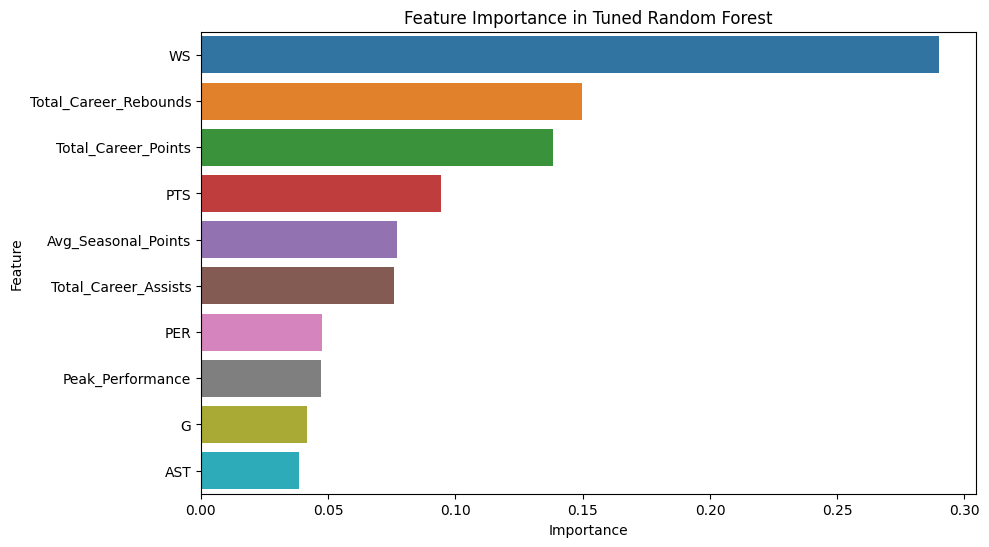

In [49]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Tuned Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## 5. Final Model

In [50]:
# Select top 10 features
top_features = ['WS', 'Total_Career_Points', 'Total_Career_Rebounds', 'PTS', 
                'Avg_Seasonal_Points', 'Peak_Performance', 'Total_Career_Assists', 
                'PER', 'G', 'AST']
X = df_processed[top_features]
y = df_processed['HOF']

In [51]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [52]:
# Train final model with best parameters
final_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, 
                                     class_weight={0: 1, 1: 10}, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=10,
                       random_state=42)

In [53]:
# Predict and evaluate
y_pred = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)[:, 1]

In [54]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Final Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Final Model Evaluation Metrics:
Accuracy: 0.9718
Precision: 0.5926
Recall: 0.4571
F1-Score: 0.5161
ROC-AUC: 0.9174


In [55]:
# Feature importance for final model
feature_importance = pd.DataFrame({'feature': top_features, 'importance': final_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance (Final Model):")
print(feature_importance)


Feature Importance (Final Model):
                 feature  importance
0                     WS    0.289984
2  Total_Career_Rebounds    0.149631
1    Total_Career_Points    0.138317
3                    PTS    0.094161
4    Avg_Seasonal_Points    0.077144
6   Total_Career_Assists    0.076008
7                    PER    0.047656
5       Peak_Performance    0.047066
8                      G    0.041514
9                    AST    0.038520


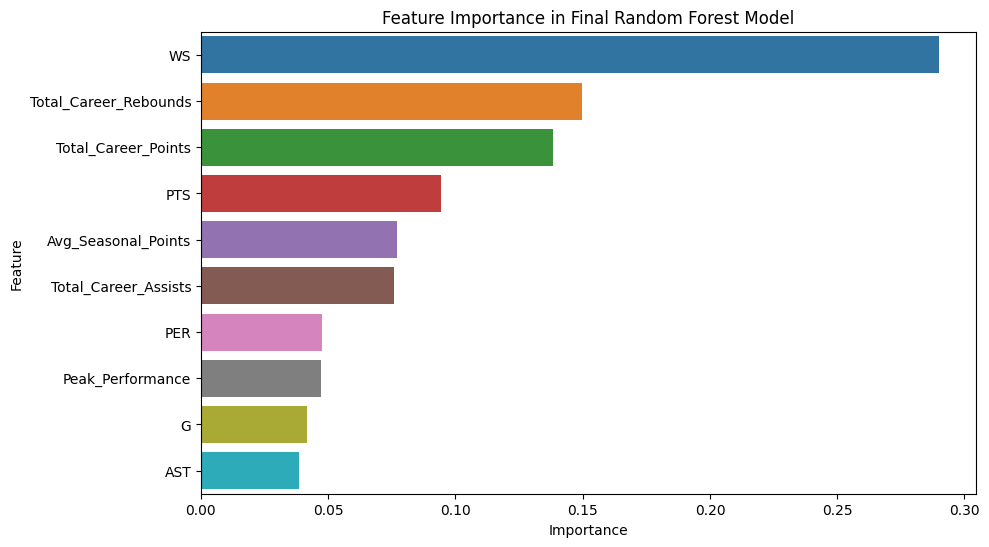

In [56]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Final Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### **Analysis of Results**

**1. Final Model Evaluation Metrics:**

- **Accuracy (0.9718):** Matches the tuned model, reflecting the class imbalance (96.67% False) and reinforcing that accuracy is less informative here.
- **Precision (0.5926):** Consistent with the tuned model, indicating reliable positive predictions for HOF True cases.
- **Recall (0.4571):** Identical to the tuned model, confirming the model identifies 45.71% of actual HOF inductees, a solid improvement from the baseline (0.3714).
- **F1-Score (0.5161):** Matches the tuned model, showing a balanced trade-off between precision and recall, validating the 1:10 class weight.
- **ROC-AUC (0.9174):** Consistent with the tuned model, indicating strong discriminative power across thresholds, a testament to the model’s overall performance.
  
**2. Feature Importance (Final Model):**

- **WS (0.28998):** Remains the top feature, with its importance slightly increased from the baseline, highlighting its critical role in HOF prediction.
- **Total_Career_Rebounds (0.14963) and Total_Career_Points (0.13832):** Retain high importance, consistent with the tuned model, reflecting the value of cumulative stats.
- **PTS (0.09416), Avg_Seasonal_Points (0.07714), and Total_Career_Assists (0.07601):** Show stable importance, with PTS gaining prominence, aligning with HOF criteria of consistent scoring.
- **PER (0.04766) and Peak_Performance (0.04707):** Slightly improved from the baseline, suggesting the model leverages efficiency and peak metrics effectively.
- **G (0.04151) and AST (0.03852):** Remain lower, with minimal changes, indicating they are less discriminative.
- The feature importance distribution mirrors the tuned model, confirming stability across training runs.
The plot visually reinforces WS as the dominant predictor, followed by Total_Career_Rebounds and Total_Career_Points, with a clear gradient to less impactful features.

**Final Validation:**

- The identical metrics between the tuned and final models suggest the GridSearchCV process effectively identified the optimal hyperparameters, and the final training on the full training set did not overfit.